In [13]:
pip install pyqubo

Note: you may need to restart the kernel to use updated packages.


In [14]:
from qat.lang.AQASM import Program, CNOT, H, RX, RY, RZ
from qat.qpus import get_default_qpu
import numpy as np
from numpy import linalg
from qat.qpus import PyLinalg
import qiskit
from qiskit import *
from qiskit.aqua.components.optimizers import COBYLA,SLSQP,SPSA
from qiskit.visualization import plot_histogram
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import scipy
from scipy import optimize

%matplotlib inline

# Otimização de Portfólio

A função objetivo para a otimização de portfólio pode ser modelada como uma função quadrática binária irrestrita. Essa função,termos do retorno, orçamento total e a matriz de covariância do portfólio, pode ser expressa como

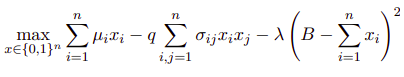

## 1. Quantum Approximate Optimization Algorithm (QAOA)

In [15]:
#matriz de covariancia
cov = [[1.08774352e-03, 2.59532811e-04, 1.80247155e-04, 3.21724369e-04],
       [2.59532811e-04, 4.43192629e-04, 7.43211072e-05, 2.27911525e-04],
       [1.80247155e-04, 7.43211072e-05, 3.89444953e-04, 1.37915422e-04],
       [3.21724369e-04, 2.27911525e-04, 1.37915422e-04, 8.75437564e-04]]

#retornos e  outros parametros da F.O.
mu = [0.31542042, 0.0571331 , 0.11430001, 0.30109367]
q=0.5
B=2
lamb=1

#cria as variaveis binarias
from pyqubo import Spin, Binary
s1, s2, s3, s4 = Spin("s1"), Spin("s2"), Spin("s3"), Spin("s4")
x1, x2, x3, x4 = Binary("x1"), Binary("x2"), Binary("x3"), Binary("x4")
X=[x1,x2,x3,x4]

# escreve o QUBO
EN = (mu[0]*X[0] + mu[1]*X[1] + mu[2]*X[2] + mu[3]*X[3] - 
         q*(cov[0][1]*X[0]*X[1] + cov[0][2]*X[0]*X[2] + cov[0][3]*X[0]*X[3] + cov[1][2]*X[1]*X[2] + 
        cov[1][3]*X[1]*X[3] + cov[2][3]*X[2]*X[3]) - 
             lamb*(B - X[0] - X[1] - X[2] - X[3]))

# cria o modelo e transforma de QUBO para Ising
model = EN.compile()
linear, quadratic, offset = model.to_ising()

# coeficientes que serão usados no Operador Gamma
coefs=[linear['x1'],linear['x2'],linear['x3'],linear['x4'],
      quadratic[('x1', 'x2')],quadratic[('x3', 'x1')],quadratic[('x4', 'x1')],
       quadratic[('x3', 'x2')], quadratic[('x4', 'x2')],quadratic[('x4', 'x3')]]



In [16]:
# OBS: NESSA CÉLULA, O QISKIT É USADO APENAS PARA VIZUALIZAÇÃO DO CIRCUITO

num_assets=4
def gamma_op(gamma):
    num_q=num_assets
    qc_gamma=QuantumCircuit(num_q)
    # iteration between p0 and p1
    
    for i in range(num_q):
        for j in range(num_q):
            if(i<j):
                qc_gamma.cx(i,j)
                qc_gamma.rz(gamma*coefs[j+4],j)
                qc_gamma.cx(i,j)
    qc_gamma.barrier()
    for i in range(num_q):
        qc_gamma.rz(coefs[i],i)

    return qc_gamma

guess=0
gamma_op(guess).draw(fold=-1)

░ ┌─────────────┐
q_0: ──■─────────────■────■─────────────■────■──────────────────────■──────────────────────────────────────────────░─┤ RZ(0.65762) ├
     ┌─┴─┐┌───────┐┌─┴─┐  │             │    │                      │                                              ░ └┬────────────┤
q_1: ┤ X ├┤ RZ(0) ├┤ X ├──┼─────────────┼────┼──────■───────────────┼────■────■─────────────■──────────────────────░──┤ RZ(0.5285) ├
     └───┘└───────┘└───┘┌─┴─┐┌───────┐┌─┴─┐  │    ┌─┴─┐  ┌───────┐  │  ┌─┴─┐  │             │                      ░  ├────────────┤
q_2: ───────────────────┤ X ├┤ RZ(0) ├┤ X ├──┼────┤ X ├──┤ RZ(0) ├──┼──┤ X ├──┼─────────────┼────■─────────────■───░──┤ RZ(0.5571) ├
                        └───┘└───────┘└───┘┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐└───┘┌─┴─┐┌───────┐┌─┴─┐┌─┴─┐┌───────┐┌─┴─┐ ░ ┌┴────────────┤
q_3: ──────────────────────────────────────┤ X ├┤ RZ(0) ├─────────┤ X ├─────┤ X ├┤ RZ(0) ├┤ X ├┤ X ├┤ RZ(0) ├┤ X ├─░─┤ RZ(0.65046) ├
                                           └───┘└───────┘         └───┘     └───┘└───────┘└───┘└───┘└───────┘└───┘ ░ └─────────────┘

In [17]:
# IMPLEMENTAÇÃO DO CIRCUITO VARIACIONAL NO MYQLM
def var_circuit(gamma, beta, num_layers, num_qubits):
    qprog = Program()    
    qubits = qprog.qalloc(num_qubits)
    
    #estado inicial: |+>^n
    for qubit in range(num_qubits):
        qprog.apply(H, qubits[qubit])

    for layer in range(num_layers):            
        #operador gamma
        
        for i in range(num_qubits):
            for j in range(num_qubits):
                if(i<j):
                    qprog.apply(CNOT, qubits[i], qubits[j])
                    qprog.apply(RZ(gamma[layer]*coefs[j+4]), qubits[j])
                    qprog.apply(CNOT, qubits[i], qubits[j])
        for i in range(num_qubits):
            qprog.apply(RZ(gamma[layer]*coefs[i]), qubits[i])
        
        # operador beta (forma variacional: emaranhamento linear)
        for i in range(num_qubits):
            qprog.apply(RY(beta[layer]), qubits[i])        
        for i in range(num_qubits-1):
            qprog.apply(CNOT, qubits[i], qubits[i+1])
        qprog.apply(CNOT, qubits[num_qubits-1], qubits[0])        
        for i in range(num_qubits):
            qprog.apply(RY(beta[layer]), qubits[i])
    
    return qprog

In [18]:
num_assets=4
num_qubits = num_assets
num_layers = 8
gamma_size = num_layers
beta_size = num_layers

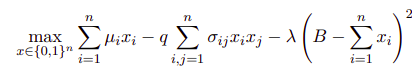

In [19]:
# ENERGIAS DO HAMILTONIANO QUE SERÃO CALCULADAS PARA OS AUTOESTADOS MEDIDOS

def energy(x,num_qubits=num_qubits):   
    H = -((mu[0]*x[0]+mu[1]*x[1]+mu[2]*x[2]+mu[3]*x[3]) - 
          q*(cov[0][1]*x[0]*x[1] + cov[0][2]*x[0]*x[2]+ 
             cov[0][3]*x[0]*x[3] + cov[1][2]*x[1]*x[2]+
             cov[1][3]*x[1]*x[3] + cov[2][3]*x[2]*x[3]) - 
              lamb*(B - x[0]-x[1]-x[2]-x[3])**2)
    return H

In [20]:
energy([1,0,0,1])

-0.6163532278155

In [21]:
def cost_function(param):
    circuit=var_circuit(param[:int((len(param)/2))], 
                        param[(int(len(param)/2)):-1], 
                        num_layers=num_layers, 
                        num_qubits=num_qubits).to_circ()
    
    job = circuit.to_job()
    result = get_default_qpu().submit(job)
    states=[]
    probs=[]
    for sample in result:
        #print(sample.state, sample.probability)
        states.append(sample.state)
        probs.append(sample.probability)
    exp_value=0
    for i in range(len(states)):
        exp_value = exp_value + energy(states[i])*probs[i]
        
    return exp_value

In [22]:
cost_function(np.zeros(2*num_layers+1))

0.6061766065486496

In [23]:
n=2
Hmin_med = []
prob1001_med = []
num_seeds=10
num_try = 20
matriz_Hmin=[]
matriz_prob1001 = []

"""
for k in range(num_try):
    
    num_layers=k
    Hmin = []
    prob1001 = []
    for i in range(num_seeds):
        np.random.seed(i)
        guess = np.random.random(2*num_layers+1)
        ret=scipy.optimize.minimize(cost_function, guess, args=(), method='COBYLA', constraints=(), tol=None, callback=None, options={'rhobeg': 1.0, 'maxiter': 1000, 'disp': False, 'catol': 0.0002})
        #optimizer = COBYLA(1000, 0.01)
        #ret = optimizer.optimize((2*num_layers+1), objective_function=cost_function, initial_point=guess)
        Hmin.append(ret['fun'])

        #guess=np.zeros(2*num_layers+1)
        #optimizer = COBYLA(2000, 0.01)
        #ret = optimizer.optimize((2*num_layers+1), objective_function=cost_function, initial_point=guess)
        #Hmin.append(ret[1])

        check = var_circuit(ret['x'][:int(len(ret['x'])/2)], 
                            ret['x'][int(len(ret['x'])/2):-1], 
                            num_layers=num_layers, 
                            num_qubits=num_qubits)


        circ=check.to_circ()
        job = circ.to_job()
        result = get_default_qpu().submit(job)
        states=[]
        probs=[]
        for sample in result:
            #print(sample.state, sample.probability)
            states.append(sample.state)
            probs.append(sample.probability)
        prob1001.append(probs[9])

        #print(probs[9], ret[1])
    
    print("<H>min média dos 3 mín.:   ",np.mean(sorted(Hmin)[:n]), "   PROB |1001> média 3 max.:   ",np.mean(sorted(prob1001)[-n:]))
    Hmin_med.append(np.mean(sorted(Hmin)[:n]))
    prob1001_med.append(np.mean(sorted(prob1001)[-n:]))
    matriz_Hmin.append(Hmin)
    matriz_prob1001.append(prob1001)
    
"""

'\nfor k in range(num_try):\n    \n    num_layers=k\n    Hmin = []\n    prob1001 = []\n    for i in range(num_seeds):\n        np.random.seed(i)\n        guess = np.random.random(2*num_layers+1)\n        ret=scipy.optimize.minimize(cost_function, guess, args=(), method=\'COBYLA\', constraints=(), tol=None, callback=None, options={\'rhobeg\': 1.0, \'maxiter\': 1000, \'disp\': False, \'catol\': 0.0002})\n        #optimizer = COBYLA(1000, 0.01)\n        #ret = optimizer.optimize((2*num_layers+1), objective_function=cost_function, initial_point=guess)\n        Hmin.append(ret[\'fun\'])\n\n        #guess=np.zeros(2*num_layers+1)\n        #optimizer = COBYLA(2000, 0.01)\n        #ret = optimizer.optimize((2*num_layers+1), objective_function=cost_function, initial_point=guess)\n        #Hmin.append(ret[1])\n\n        check = var_circuit(ret[\'x\'][:int(len(ret[\'x\'])/2)], \n                            ret[\'x\'][int(len(ret[\'x\'])/2):-1], \n                            num_layers=num_layers,

In [25]:
melhor_seed = np.index(max(matriz_prob1001[-1]))

import scipy
from scipy import optimize
num_layers=20
np.random.seed(melhor_seed)
guess = np.random.random(2*num_layers+1)
ret=scipy.optimize.minimize(cost_function, guess, args=(), method='COBYLA', constraints=(), tol=None, callback=None, options={'rhobeg': 1.0, 'maxiter': 1000, 'disp': False, 'catol': 0.0002})


In [ ]:
ret

In [ ]:
ret['fun']

In [ ]:
check = var_circuit(ret['x'][:int(len(ret['x'])/2)], 
                    ret['x'][int(len(ret['x'])/2):-1], 
                    num_layers=num_layers, 
                    num_qubits=num_qubits)


circ=check.to_circ()
job = circ.to_job()
result = get_default_qpu().submit(job)
states=[]
probs=[]
for sample in result:
    print(sample.state, sample.probability)
    states.append(sample.state)
    probs.append(sample.probability)
    
strings = ['0000','0001','0010','0011','0100','0101','0110','0111',
           '1000','1001','1010','1011','1100','1101','1110','1111']
x = np.arange(len(states))
plt.bar(x, height=probs)
plt.xticks(x, range(len(states)))
plt.xlabel('Bitstring')
plt.ylabel('Probabilidade')

In [ ]:
probs[9]

In [ ]:
width=1
plt.bar(strings, probs, width=width, color='black')
plt.xlabel('Autoestado', size=14)
plt.ylabel('Probabilidade', size=14)
plt.title('Distribuição de Probabilidades', size=14)
plt.xticks(x, strings, rotation=60)


In [ ]:

plt.xticks(range(len(prob1001_med)))
plt.plot(range(len(prob1001_med)), prob1001_med, 'r-',linewidth = 2.5 )
plt.title("Probabilidade média de medida da solução ótima", size=14)
plt.ylabel(r'$|\langle\psi|1001\rangle|^2$', size=14)
plt.xlabel("Número de camadas", size=14)
plt.axis([0, 19, 0, 1])
plt.grid(True)

In [ ]:
len(Hmin_min)

In [ ]:
plt.xticks(range(len(Hmin_med)))
plt.plot(range(len(Hmin_med)), Hmin_med, 'r-',linewidth = 2.5)
plt.plot(range(len(Hmin_med)),energy([1,0,0,1])*np.ones(len(Hmin_med)),'b--',linewidth = 1.5)
plt.legend([["Valor esperado"],["Referência"]])
#plt.scatter(range(len(Hmin_avg)), Hmin_avg, color='red')
plt.title("Convergência do QAOA", size=14)
plt.ylabel(r'$F_p$', size=14)
plt.xlabel("Número de camadas", size=14)
plt.axis([0, 19, -0.67, 0.70])
plt.grid(True)

In [ ]:
print(Hmin_med)

In [ ]:
print(prob1001_med)

In [ ]:
hmin_medio =  [0.6061766065486496, 0.17836510711779163, -0.14456893754867522, -0.2582313220602446, 
               -0.293773793987471, -0.40172953314634585, -0.40953743211484966, -0.4306572552154402, 
               -0.4861908610201873, -0.5073434406602844, -0.51758003073471, -0.5215805651251304, 
               -0.5516108644318953, -0.5524778373189512, -0.5606964937513081, -0.5719488399047072, 
               -0.573618300106951, -0.5800092726055128, -0.5844654751374043, -0.5859898404539589]

prob1001_medio =  [0.045857881096816384, 0.04950216535612034, 0.06249999999999996, 0.20078178031034216, 
                   0.3583504192207148, 0.4061946180447342, 0.5052778284727155, 0.5764162853762655, 
                   0.5880398756134942, 0.6416258654280796, 0.6840318741543814, 0.6885280633291896, 
                   0.7602968015991218, 0.8088898547683037, 0.8265747456807642, 0.8704318581095074, 
                   0.8716188768429468, 0.8823196623298313, 0.8891028927946059, 0.926372334857174]

In [ ]:

plt.xticks(range(len(prob1001_medio)))
plt.plot(range(len(prob1001_medio)), prob1001_medio, 'r-',linewidth = 2.5 )
plt.title("Probabilidade média de medida da solução ótima", size=14)
plt.ylabel(r'$|\langle\psi|1001\rangle|^2$', size=14)
plt.xlabel("Número de camadas", size=14)
plt.axis([0, 19, 0, 1])
plt.grid(True)

In [ ]:
plt.xticks(range(len(hmin_medio)))
plt.plot(range(len(hmin_medio)), hmin_medio, 'r-',linewidth = 2.5)
plt.plot(range(len(hmin_medio)),energy([1,0,0,1])*np.ones(len(hmin_medio)),'b--',linewidth = 1.5)
plt.legend([["Valor esperado"],["Referência"]])
#plt.scatter(range(len(Hmin_avg)), Hmin_avg, color='red')
plt.title("Convergência do QAOA", size=14)
plt.ylabel(r'$F_p$', size=14)
plt.xlabel("Número de camadas", size=14)
plt.axis([0, 19, -0.67, 0.70])
plt.grid(True)